# Getting Started

The first thing you need to create our virutal environment. Let's let VSCode do this for us. Click 'Select Kernel' in the upper right hand and do 'New Python Environment'. You can use a python enviornment. We can use PIP or Anaconda.

### Anaconda

You should use Aanaconda if you plan to do future research that involves informatics. It is a package manager with better support for ensuring your python package dependencies, ensuring they work more consistently; however, [PIP](#pip) is easier to use out of the box without additional installation.

If you're using Anaconda and do not have it yet, download it from here [https://www.anaconda.com/download/success](https://www.anaconda.com/download/success).

### PIP

If you installed Anaconda, skip this section. Otherwise we'll be using PIP. It's a bit easier at first but is more brittle and not as good a choice for research. We will need to set up a virtual environment.

## Setting up the Virtual Enviornment

It is best practice to set up a 'virtual environment' where python modules will be installed in an isolated space on your computer that we can eventually delete without affecting your computer in a larger scale. 

In the menu bar in VS Code, click `Terminal` and `New Terminal`, then insert this shell script.

### Windows 
```sh
.\configure.bat
```
### MacOS or Linux
```sh
chmod +x ./configure.sh # Lets us use the install script
./configure.sh # Runs the script
```
The path to the virtual environment kernel will be printed at the end of this.

Now we should start using the new virtual enviornment. In the upper right hand of this document click `Select Kernel` and use the path provided.

### Turn on AutoReload
This ensures that changes to the modules we write in the `./src/` directory are reloaded by this notebook each time. Otherwise your changes will be ignored.

In [1]:
from IPython.extensions import autoreload
%load_ext autoreload
%autoreload 2

# Our Lab Informatics System Database Schema

Here is the Database Schema for our example laboratory informatics system (LIS). 

![Reload if you can't see this](LIS.svg)

# Importing our Python Source

Instead of defining all of our functions within the notebook, we will define our functions outside of the notebook to make the project modular. 

We will import the source from the src directory:
```py
from src.qc import print_sql_table, get_qc_data
```

After this we can start using the data.

# Getting the Data
Unlike the work we did in our [Google Colab Notebook](https://colab.research.google.com/drive/1oskiQwGFTW1RC8T28wah4uTfixJ3TNEv?authuser=1), we will use [Pandas](https://pandas.pydata.org/getting_started.html) for data frame maniputation. Essentially, instead of iterating through rows manually like I taught you, Pandas will do most of that for us. [Please quickly learn about Pandas here](https://www.w3schools.com/python/pandas/default.asp).

In [2]:
# Lets test our import and execute a simple query to see if it works
from src.qc import print_sql_table, get_qc_data
print_sql_table("SELECT * from analyzers LIMIT 5;")

id | loinc  | name             | rr_upper_bound | rr_lower_bound | units
------------------------------------------------------------------------
1  | 2951-2 | Sodium, Plasma   | 146.0          | 136.0          | 21   
2  | 2823-3 | Potassium, Serum | 5.0            | 3.5            | 21   


In [3]:
from src.qc import get_data
# Instead of printing the table, let's get it as a DataFrame and print that
data_frame = get_data("SELECT * from demographics LIMIT 5;")
print(data_frame)

# You should be able to see data_frame in 'Data Wrangler'
# It can be viewed like a spreadsheet, and you can also see the data types of each column.
# This is useful for understanding the structure of the data and for debugging any issues with data types when performing analysis or visualization later on.

   id     mrn name_first  name_last name_middle         dob        ssn  \
0  31  596124      Nancy     Oliver      Thomas  1999-04-12  693958214   
1  32  357314      Nancy      Lucas       Diane  1967-11-25  755919963   
2  33  931802     Nicole     Garcia         NaN  1933-08-29  679166778   
3  34  798840      Raven     Savage    Madeline  1935-01-04  164304383   
4  35  731370     Daniel  Hernandez         NaN  1965-04-28  493268341   

   gender  biologic_sex  
0       2             2  
1       1             1  
2       2             2  
3       4             2  
4       1             2  


# Visualizing the Data

We will import some visualization source from the src directory:
```py
from src.visualization import generate_QC_graph
```

You will see if you look within the src director that I have already defined the function ```generate_QC_graph```. Let's use that now to see both the patient and QC Data:

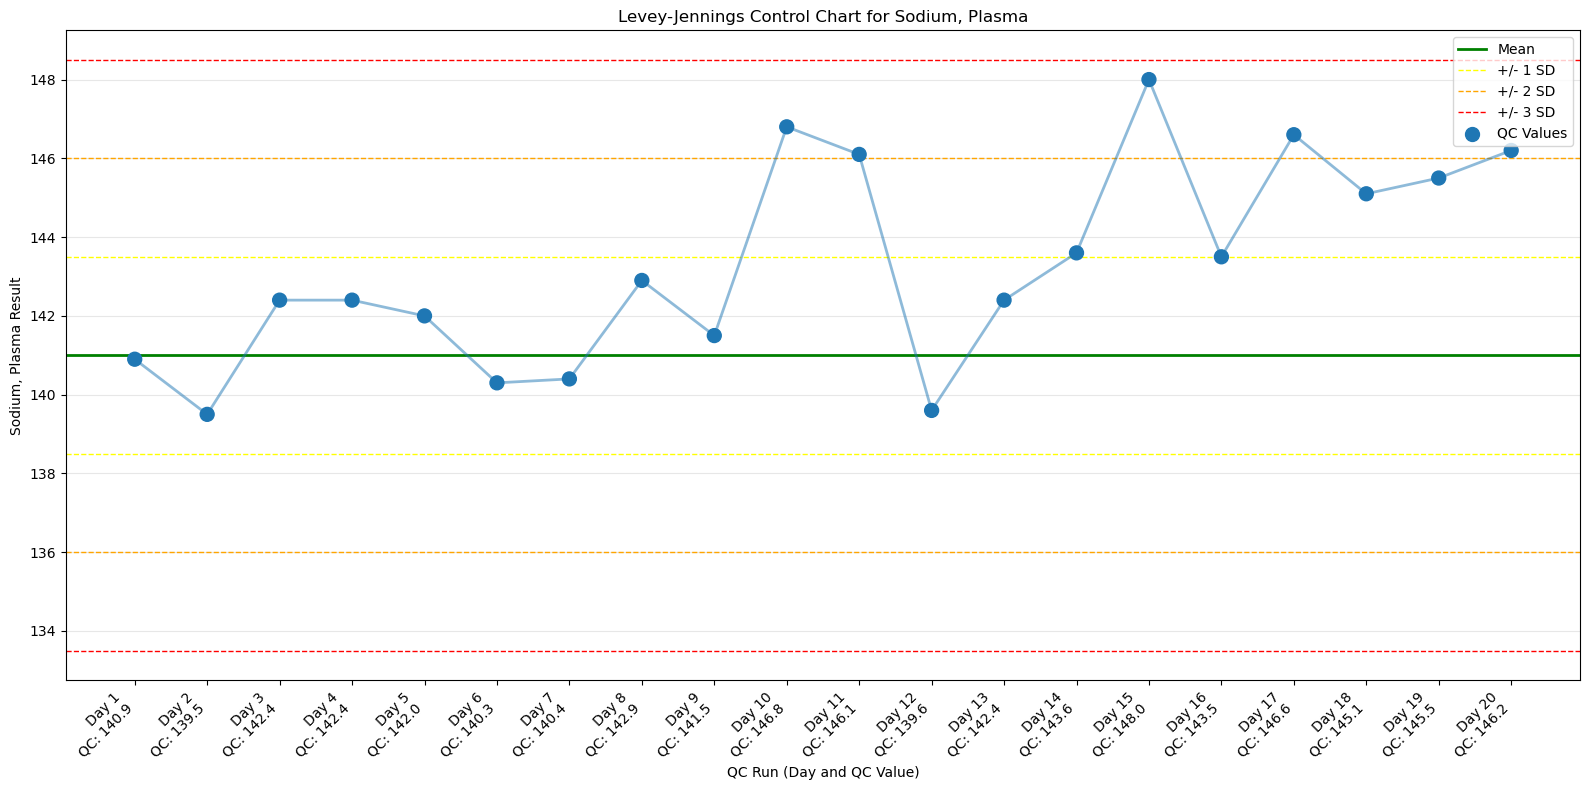

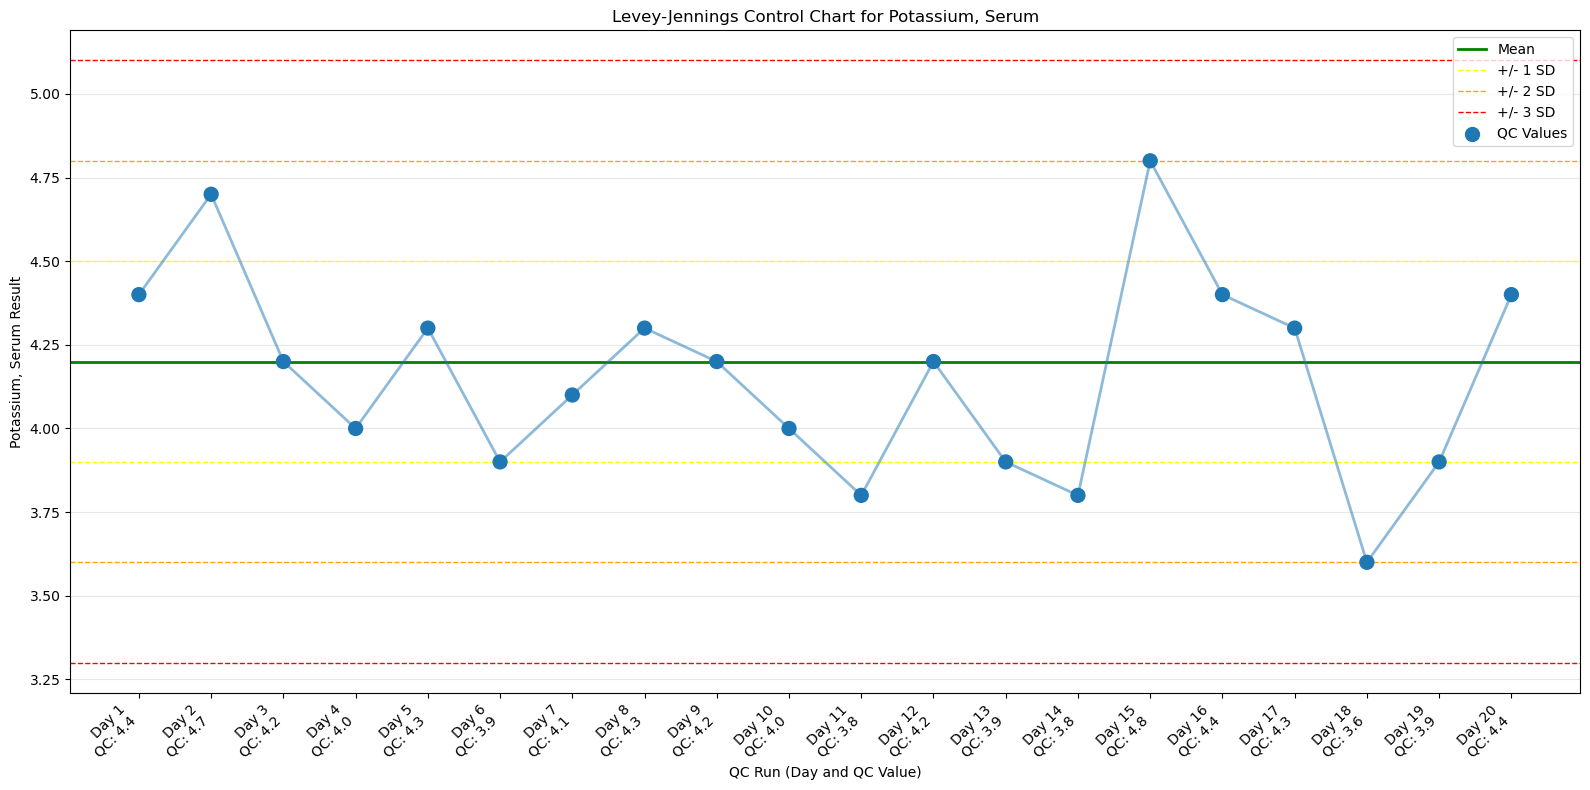

In [8]:
from src.qc import get_patient_results, perform_westguard_analysis
from src.visualization import generate_QC_graph

# Get the data

df_sodium = get_qc_data('Sodium, Plasma')
mean = 141.0
sd = 2.5
warnings, failures = perform_westguard_analysis(df_sodium['result'], mean, sd)
fake_rr_sodium_lower, fake_rr_sodium_upper = 136.0, 146.0
generate_QC_graph(df_sodium, 'Sodium, Plasma', mean=mean, sd=sd)

# For Potassium
df_potassium = get_qc_data('Potassium, Serum')
mean = 4.2
sd = 0.3
warnings, failures = perform_westguard_analysis(df_potassium['result'], mean, sd)
generate_QC_graph(df_potassium, 'Potassium, Serum', mean=mean, sd=sd)

# Running the Westgard Rules

Please [read this](https://westgard.com/westgard-rules.html) ([https://westgard.com/westgard-rules.html](https://westgard.com/westgard-rules.html)) over if you are unfamiliar with Westgard Rules for QC. 

In this we will we write code to evaluate the following rules. We will get a Pandas dataframe 
```py
df_sodium = get_qc_data('Sodium, Plasma')
# Get the reference ranges, defined here as mean + 2 * SD
rr_lower, rr_upper = get_reference_ranges('Sodium, Plasma')
# Get the mean
mean = (rr_lower + rr_upper)/2
# Get one standard deviation (as RR is defined as mean + 2 * SD)
sd = (mean + rr_upper)/2
```

### 13S Rule
A run is rejected when a single control measurement exceeds the mean plus 3s or the mean minus 3s control limit.

![13S Diagram](https://westgard.com/images/stories/mrf2.gif)

Psudocode:
```py
# We will make a boolean list (True/False) of if each result violates this rule.
# In coding this is called a 'mask'
qc_results = df_sodium["result"]
mask = (qc_results > mean + 3*sd) | (qc_results < mean - 3*sd)
# Mask says 'is this result > or < mean + 3 * sd?'
# We then will turn this list of [True, False, False, True] into 
# The an indexes list -> [0, 3]
failures_13S = df_sodium[mask]
```

### 12S Rule
In the original Westgard multirule QC procedure, this rule is used as a warning rule to trigger careful inspection of the control data by the following rejection rules.

![12S Diagram](https://westgard.com/images/stories/mrf2.gif)

Psudocode:
```py
qc_results = df_sodium["result"]
mask = (qc_results > mean + 2*sd) | (qc_results < mean - 2*sd)
warnings_12S = df_sodium[mask]
```

### 2S2
Reject when 2 consecutive control measurements exceed the same mean plus 2s or the same mean minus 2s control limit.

![12S Diagram](https://westgard.com/images/stories/mrf2.gif)

Psudocode:
```py
qc_results = df_sodium["result"]

# the 2S2 Rejection requires BOTH to be on the SAME SIDE
# Therefore we need two lists the upper (to compare with itself) 
# and lower (to again compare with itself)
upper_2S = qc_results > mean + 2*sd
lower_2S = qc_results < mean - 2*sd

# Now we will make a mask. It says if upper and upper, shifted right by 1, are both
# 'True' ie above mean + 2 * SD, then we say yes this failed.
# We also need to go the other direction, if upper and upper, shifted left by 1, are both
# 'True' ie above mean + 2 * SD, then we say yes this failed.
# This ensures both values are considered failures, not just the second.
mask = upper_2S & upper_2S.shift(1) | upper_2S & upper_2S.shift(-1) | lower_2S & lower_2S.shift(1) | lower_2S & lower_2S.shift(-1)

# Finally take those and return the masked values. 
failures_2S2 = df_sodium[mask]
```

In [ ]:
# Workspace to experiment with the Westguard Rules

from src.qc import get_qc_data
df_sodium = get_qc_data('Sodium, Plasma')
mean = 141.0
sd = 2.5
#Start working here

# Generating our Report

Let's start by 

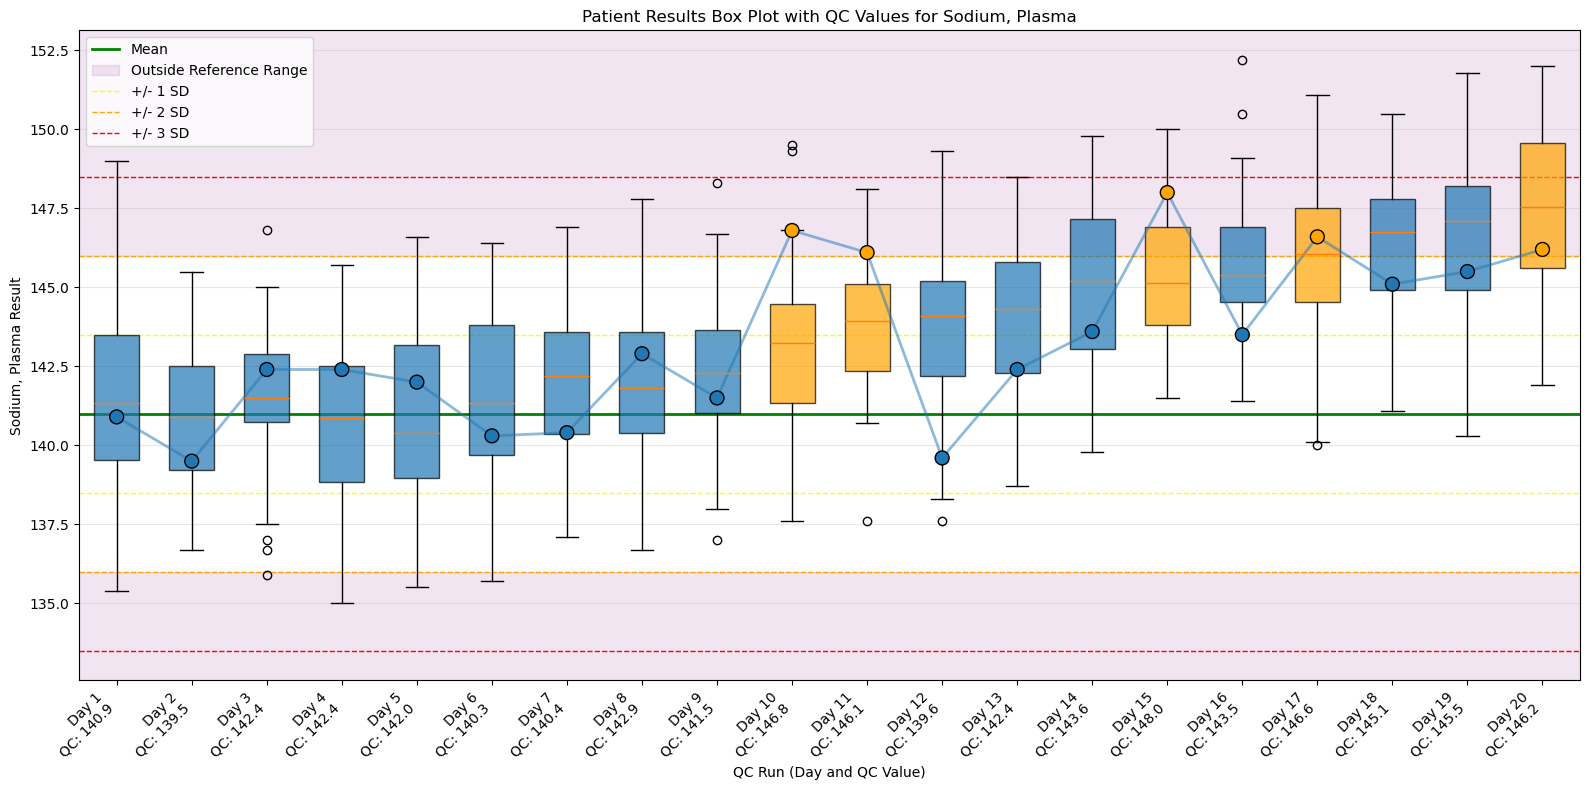

In [ ]:
from src.qc import get_patient_results, get_qc_data, perform_westguard_analysis, get_reference_ranges
from src.visualization import generate_westguard_graph

# Get patient results data
df_sodium = get_patient_results('Sodium, Plasma')

# Get QC data separately for Westguard analysis
df_qc_sodium = get_qc_data('Sodium, Plasma')

# Get reference ranges for Sodium, Plasma to use in the graph
rr_lower, rr_upper = get_reference_ranges('Sodium, Plasma')

# Mean and SD for the graph should be based on QC analytes
# For simplicity, we will use the reference range to set the mean and SD for QC data.
mean = (rr_upper + rr_lower) / 2
sd = (rr_upper - mean) / 2

# Perform Westguard analysis on QC values (not patient results)
warnings, failures = perform_westguard_analysis(df_qc_sodium['result'], mean, sd)

# Generate the graph with patient results but QC-based warnings/failures
generate_westguard_graph(df_sodium, 'Sodium, Plasma', 
                  mean=mean, sd=sd, 
                  ref_lower=rr_lower, 
                  ref_upper=rr_upper, 
                  warnings=warnings, 
                  failures=failures)